# Clustering

Conforme visto no notebook anterior não foi possível obter bons resultados com dados. Assim iremos propor aqui utilizar apenas as amostras nas quais as pessoas utilizaram o Canabidiol (CBD), realizando uma clusterização em cima desses dados.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import f_oneway

#Estilo ggplot
plt.style.use('ggplot')

# 1. Leitura dos dados

In [2]:
#Setando diretorio Data como o atual
os.chdir('../Data')

#Leitura
df_parkinson = pd.read_csv('parkinson_v2.csv',index_col = 'name')

# 2. Transformação dos dados

Nessa seção iremos criar os outros atributos para wpsf seguindo a fórmula wpsf = psp * pspf. Também faremos uma diminuição das features no domínio da frequência ao calcular sua média por amostra.

Por fim, aplicaremos o log no intuito de distribuir mais os valores das features (existe uma assimetria muito grande) e iremos padronizá-las para o intervalo [0,1].

In [3]:
#Criacao de novas colunas
df_parkinson['wpsf2'] = df_parkinson['pspf2'] * df_parkinson['psp2']
df_parkinson['wpsf3'] = df_parkinson['pspf3'] * df_parkinson['psp3']
df_parkinson.rename(columns={'wpsf':'wpsf1'},inplace=True)

#Medias dos psp's e pspf's
df_parkinson['psp'] = df_parkinson[['psp1','psp2','psp3']].apply(lambda x: x.mean(),axis=1)
df_parkinson['pspf'] = df_parkinson[['pspf1','pspf2','pspf3']].apply(lambda x: x.mean(),axis=1)
df_parkinson['wpsf'] = df_parkinson[['wpsf1','wpsf2','wpsf3']].apply(lambda x: x.mean(),axis=1)

#Dropando colunas que nao sai mais interessantes
y = df_parkinson['drug']
df_parkinson = df_parkinson.drop(columns=['drug','evaluate','measure','psp1','psp2','psp3','pspf1','pspf2','pspf3','wpsf1','wpsf2','wpsf3'])

#Aplicando log
positive_cols = (df_parkinson <= 0).any()
positive_cols = positive_cols[~positive_cols].index
df_parkinson.loc[:,positive_cols] = np.log(df_parkinson.loc[:,positive_cols])

#Reescalando variaveis
mm = MinMaxScaler().fit(df_parkinson)
df_parkinson.iloc[:,:] = mm.transform(df_parkinson)

#Setando valor da droga novamente
df_parkinson['drug'] = y

#Dividindo datset por tipo de droga
df_cbd = df_parkinson.loc[df_parkinson['drug'] == 'CBD']
df_placebo = df_parkinson.loc[df_parkinson['drug'] == 'placebo']

#Excluindo target por nao ser mais necessario
del df_cbd['drug']
del df_placebo['drug']

# 3. Modelagem - Testes

## 3.1 Redução de dimensionalidade e clusterização com todos os atributos

Como temos muitos atributos iremos aplicar o PCA para reduzir a dimensionalidade dos dados e em seguida realizar a clusterização.

In [4]:
'''Plota varios boxplot definido por x e cols'''
def boxplot(df,cols,x):
    
    #Iremos plotar 3 graficos por linhas
    ncol = 3
    
    #Numero de linhas é calculado automaticamente
    nrow = int(len(cols)/3)+1
    
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    for index,c in enumerate(cols):
        ax = fig.add_subplot(nrow,ncol,index+1)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        sns.boxplot(data=df,x=x,y=c)
    plt.show()
    
'''Plota um pairplot customizado'''
def pairplot(df,col_plot,hue):
    
    #Pairplot
    g = sns.pairplot(data=df,hue=hue,vars=col_plot)

    #Quantidade de colunas para plotar
    n = len(col_plot)
    
    #Customizando figura
    for index in range(n):
        
        #Muda o tamanho de xticklabels 
        for tick_x in g.axes[n-1][index].get_xticklabels():
            tick_x.set_fontsize(13)

        #Muda o tamanho de yticklabels
        for tick_y in g.axes[index][0].get_yticklabels():
            tick_y.set_fontsize(13)

        #Muda o tamanho de xlabel/ylabel
        g.axes[n-1][index].xaxis.label.set_size(15)
        g.axes[index][0].yaxis.label.set_size(15)

    #Muda tamanho das legendas
    g.fig.get_children()[-1].properties()['title'].set_fontsize(15)
    g.fig.get_children()[-1].prop.set_size(15)
    plt.show()
    
'''Plot da variância explicada do PCA'''
def plot_pca(pca,size):
    #Plot dos 'size' primeiros PC's
    x_list = []
    for i in range(size):
        x_list.append('PC' + str(i+1))

    #Criando figura
    fig,ax = plt.subplots(figsize=(15,7))
    ax.set_title('Explained variance by different principal components')
    ax.bar(height=pca.explained_variance_ratio_[0:size],x=x_list,width=0.9,label='Individual')
    ax.plot(x_list,np.cumsum(pca.explained_variance_ratio_[0:size]),marker='o',color='orange',label='Cumulative')
    
    #Rotaciona xticklabels em 45 graus
    for xtick in ax.get_xticklabels():
        xtick.set_rotation(45)
    
    ax.legend()
    plt.show()
    
'''Plot dos loagind vectors do PCA com os dados transformados.'''
def plot_pca_loading(df_pca,df_loading,hue=None):
    
    #Criando figura
    fig , ax = plt.subplots(figsize=(9,7))

    #Scatterplot
    sns.scatterplot(x='PC1',y='PC2',data=df_pca,hue=hue,palette='seismic',ax=ax)

    #Setando limites nos eixos
    ax.set_xlim(-1,1.5)
    ax.set_ylim(-1,1.5)

    #Linhas de referencia
    ax.hlines(0,-1.5,1.5, linestyles='dotted', colors='grey')
    ax.vlines(0,-1.5,1.5, linestyles='dotted', colors='grey')

    #Labels em x/y
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')

    #Plot dos labels e vetores
    offset = 1.3 #Offset para separar os labels dos vetores
    shift = 0.05 #Shift dos labels com os vetores
    for index,value in df_loading.iterrows():
        #Labels
        ax.annotate(index, (value['V1']*offset+shift, value['V2']*offset), color='darkblue',fontsize=15)

        #Vetores
        ax.arrow(0,0,value['V1']*offset, value['V2']*offset,color='black',width=0.02)

    plt.show()
    
'''Aplica a transformação pca nos dados.'''
def pca_transform(pca,df,n):
    #Criando dataframe a partir da transformacao do pca
    df_pca = pd.DataFrame(pca.transform(df)[:,0:n])

    #Loading vectors
    df_loading = pd.DataFrame(pca.components_,index=df.columns,columns=['V' + str(i+1) for i in range(len(pca.components_))])

    #Renomeando colunas
    df_pca.columns = ['PC' + str(c+1) for c in df_pca.columns]
    
    return df_pca,df_loading

'''Plota um gráfico de radar.'''
def radar_plot(df):
        
    #Numero de features
    features = df.columns.values
    N = len(features)

    #Deixando em maiusculo
    features = [i.upper() for i in features]

    #Inicializa figura
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    ax.set_title('Comparação das características em cada grupo')

    #Plota um radar plot para cada amostra
    for i in range(len(df)):

        #Valores a serem plotados
        values = df.iloc[i].values.tolist()

        #Angulos para o plot
        angles = [n / float(N) * 2 * pi for n in range(N)]

        #Tornando circular
        values += values[:1]
        angles += angles[:1]

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], features, color='grey', size=13)

        #Plot os dados
        ax.plot(angles, values, linewidth=1, linestyle='solid')

        #Preenche area
        ax.fill(angles, values, 'b', alpha=0.1)

    #Ylabels
    ax.set_rlabel_position(0)
    yticks = np.linspace(df.values.min(),df.values.max(),4)
    plt.yticks(yticks[:-1], [str(round(i,2)) for i in yticks[:-1]], color="grey", size=13)
    plt.ylim(0,yticks[-1])
        
    #Legenda
    ax.legend(['Grupo ' + str(i) for i in range(len(df))])
    plt.show()
    
'''
    Realiza a clusterização com o kmeans
    Retorna uma cópia do dataframe com a classe predita.
'''
def clustering(df,normalize=True,n_clusters=2):
    
    #Copia dataframe
    df_cluster = df.copy()
    
    #Normaliza
    if(normalize):
        df_cluster = pd.DataFrame(MinMaxScaler().fit_transform(df_cluster),columns=df_cluster.columns)
    
    #Criando KMeans
    kmeans = KMeans(n_clusters=n_clusters).fit(df_cluster)

    #Predizendo clusters
    df_cluster['target'] = kmeans.predict(df_cluster)
    
    return df_cluster

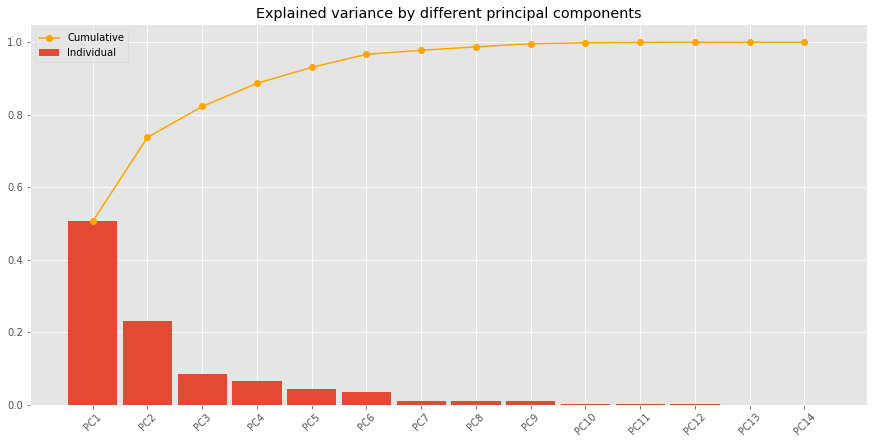

In [5]:
#Criando o PCA
pca = PCA().fit(df_cbd)

#Plot dos PC's
plot_pca(pca,df_cbd.shape[1])

Até o quinto PC temos aproximadamente 90% de explicação dos dados. Logo, vamos utilizar os 5 primeiros componentes.

In [6]:
#Transformando dados
df_cluster1,df_loading = pca_transform(pca,df_cbd,5)

Vamos aplicar a clusterização nos dados após o PCA.

In [7]:
#Criando KMeans
kmeans = KMeans(n_clusters=4,random_state=0).fit(df_cluster1.select_dtypes('float'))

#Predizendo classes
df_cluster1['target'] = kmeans.predict(df_cluster1.select_dtypes('float'))

Vamos plotar os dados para ver o que podemos interpretar.

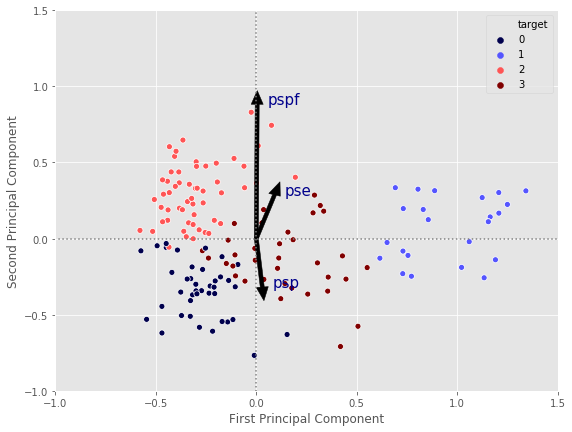

In [8]:
#Filtrando pelos valores necessarios para o plot
df_loading = df_loading.loc[['pse','psp','pspf'],['V1','V2']]

# PCA plot
plot_pca_loading(df_cluster1,df_loading,'target')

Podemos ver pela figura acima que o grupo 0 tende a possuir valores maiores em PSP e menores em PSPF/PSE. Enquanto isso o grupo 2 atua no sentido contrário

Antes de interpretar o gráfico acima precisamos entender os seguintes pontos:

- PSPF indica a variação (tremor) nas pessoas.
- PSE representa uma medida de entropia de modo que quanto maior o domínio de apenas uma amplitude da frequência menor será o seu valor. Assim, sistemas mais bagunçados, ou seja, com amplitudes maiores e menores misturadas terão um valor de PSE maior. Podemos interpretar, portanto, o PSE como uma indicação de suavidade do movimento.
- PSP representa as amplitudes das frequências. Podemos interpretar, portanto, como o quão regular é o movimento.

Assim, a partir dessas ideias temos que o grupo 0 supostamente é o mais afetado pelo CBD dado que seus movimentos são caracterizados por serem mais regulares, suaves e com uma variação menor. Da mesma maneira, o grupo 2 pode ser interpretado de maneira contrária.

## 3.2 Clusterização sem PCA em features no domínio da frequência

Muitos dos atributos gerados não possuem um significado interessante para avaliar os clusters. Por causa disso faremos uma clusterização nos seguintes atributos:

- psp
- pse
- pspf

E então avaliaremos os resultados também.

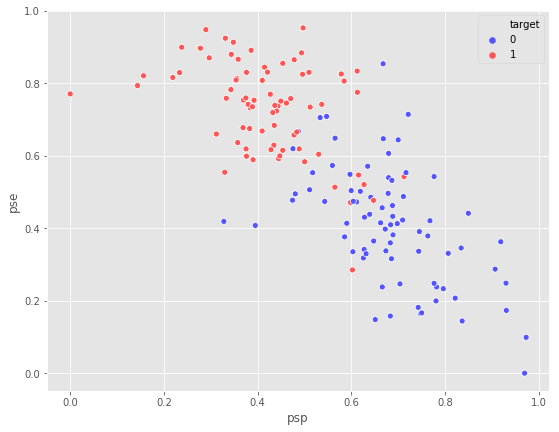

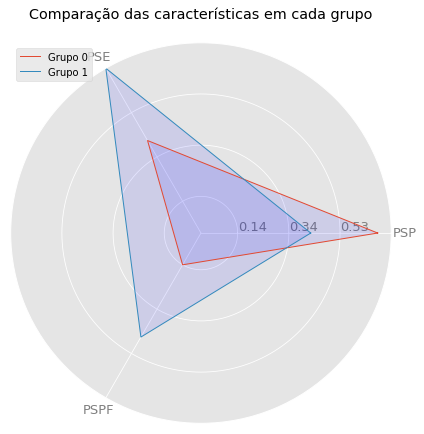

In [9]:
#Copiando dados
df_cluster2 = df_cbd[['psp','pse','pspf']].copy()

#Criando KMeans
kmeans = KMeans(n_clusters=2,random_state=0).fit(df_cluster2)

#Predizendo as classes
df_cluster2['target'] = kmeans.predict(df_cluster2)

#Scatterplot
fig,ax = plt.subplots(figsize=(9,7))
sns.scatterplot(x='psp',y='pse',data=df_cluster2,palette='seismic',hue='target',ax=ax)
plt.show()

#Radar plot
radar_plot(df_cluster2.groupby('target').mean())

Pelas ideias descritas anteriomente temos que o grupo 0 seria o mais afetado pelo CBD e o 1 atuaria de maneira oposta. No radar plot nós vemos a mesma tendência do scatterplot.

# 4. Comparação das amostras do cluster de CBD com placebo

Como o experimento realizado com as pessoas desse estudo foi realizado de maneira cruzada, sabemos que uma pessoa ora tomou placebo ora CBD. Justamente por causa disso iremos comparar as amostras dentro dos clusters criados a partir de pessoas que apenas usaram CBD com o placebo nas diferentes avaliações.

O intuito aqui é avaliar se houve uma mudança de estado. Por exemplo, gostaríamos de verificar se as amostras do cluster 0 (mais afetado pelo CBD) tiverem uma mudança comparado quando usaram o placebo ou se na verdade essas amostras estão dispostas no mesmo espaço de dados.

In [10]:
#Copiando dados
df_cluster3 = df_placebo[['psp','pse','pspf']].copy()

#Setando classes para as mesmas pessoas porem que usaram placebo
df_cluster3['target'] = df_cluster2['target'].values

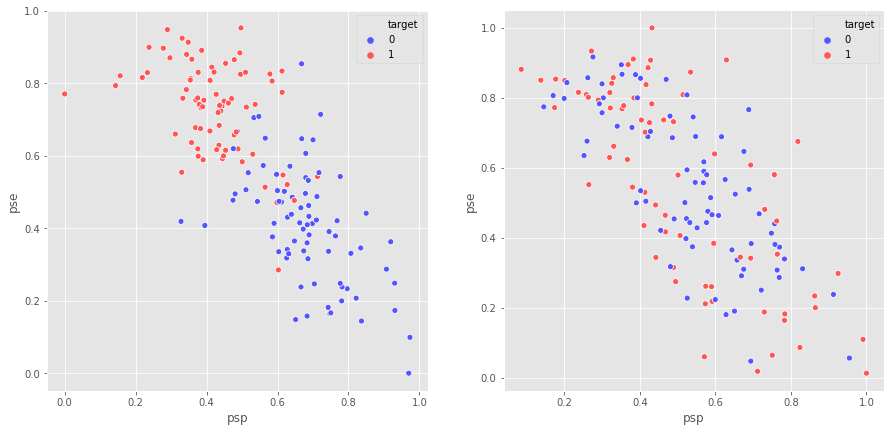

In [11]:
#Scatterplot - comparacao
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
sns.scatterplot(x='psp',y='pse',data=df_cluster2,palette='seismic',hue='target',ax=ax)
ax = fig.add_subplot(122)
sns.scatterplot(x='psp',y='pse',data=df_cluster3,palette='seismic',hue='target',ax=ax)
plt.show()

Lembrando pelas análises anteriores que o cluster 0 é o mais afetado pelo CBD enquanto que o 1 atua em direção oposta. Podemos, portanto, verificar os seguintes pontos:

- Existem pessoas do cluster 0 que anteriormente tinham movimentos menos regulares e suaves. Portanto, podemos ver que houve uma melhora para elas. Contudo, também existe aquelas que aparentam já estar no mesmo espaço independente do uso da droga.
- Existem pessoas do cluster 1 que após usar CBD aparentam ter uma piora e da mesma forma que anteriomente algumas delas já se encontravam no mesmo espaço independente do uso da droga.

Por esses gráficos já podemos perceber que o uso do CBD pode ocasionar em melhoras ou pioras e em algunas casos não realizar mudanças. Como não possuímos uma grande quantidade de dados tais fenômenos podem ser simplesmente aleatórios ou pode ser que exista realmente essa ação da droga, i.e, melhora em alguns e piora em outras ou nenhum efeito.

# 5. Estatísticas dos clusters

Pelas modelagens anteriores verificamos que é possível utilizar duas abordagens, ou seja, em ambas conseguimos bons resultados.

Iremos a seguir trabalhar em cima da clusterização sem PCA nos atributos pse, psp e pspf para gerar estatísticas dos clusters.

In [12]:
#Selecionando apenas as features
df_parkinson = df_parkinson.select_dtypes('float')

#Restaurando dados originais
df_parkinson = pd.DataFrame(mm.inverse_transform(df_parkinson),columns=df_parkinson.columns)

#Salvando dados - criando um backup
df_parkinson.to_csv('parkinson_clustering.csv',index=False)

In [13]:
#Leitura
df_cbd = pd.read_csv('parkinson_clustering.csv')[['pse','psp','pspf']]

In [14]:
#Clusterizando
df_cluster = clustering(df_cbd,n_clusters=2)

In [15]:
#Estatísticas de cada grupo - média
df_cluster.groupby('target').mean()

,pse,psp,pspf
target,,,
0,0.741175,0.395734,0.478065
1,0.397528,0.663650,0.152377


Vamos verificar se existem diferenças significativas nos grupos em pse e psp por meio da ANOVA.

In [16]:
#ANOVA
_,pvalue = f_oneway(df_cluster.loc[df_cluster['target'] == 0].select_dtypes('float'),df_cluster.loc[df_cluster['target'] == 1].select_dtypes('float'))
dict(zip(df_cluster.columns.values[:-1],pvalue))

{'pse': 9.634424326260085e-55,
 'psp': 5.087321439509349e-50,
 'pspf': 4.728125632165684e-41}

Pelo ANOVA verificamos que existem diferenças nos grupos em todos os atributos.

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


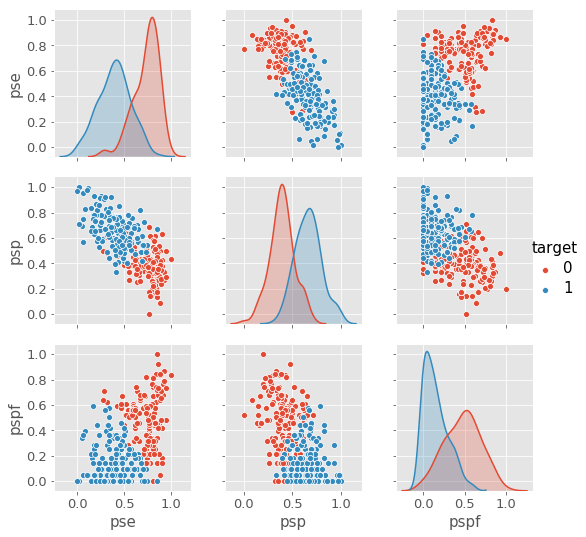

In [17]:
#Pairplot
pairplot(df_cluster,df_cluster.columns[:-1],'target')

Vamos analisar o pairplot:

- PSP x PSE: O grupo 0 possui movimentos mais regulares e mais sauves devido a maiores valores em PSP e menores em PSE. Grupo 1 atua de maneira contrária.
- PSPF x PSE: O grupo 0 possui movimentos com menor variação (tremor) devido a baixos PSPFS e movimentos mais regulares (PSE). Grupo 1 atua de maneira contrária.
- PSPF x PSP: O grupo 0 possui movimentos com menor variação (tremor) devido a baixos PSPFS e mais sauves (PSP). Grupo 1 atua de maneira contrária.

# 6. Conclusão

Pelas análises nos clusters realizadas verificamos que é possível através do agrupamento criar grupos que sejam úteis para interpretação, de modo que são bem diferentes entre si. Tais clusters podem auxiliar na tomada de decisão ao verificar o efeito que um paciente possui ao utilizar o CBD.

Notamos também que a ação da droga nos organismos difere de pessoa para pessoa. Enquanto alguns aparentam ter uma melhora, em outras temos pioras e também é possível que não exista nenhum efeito. Na verdade, essas considerações já havíam sido notadas antes mesmos da clusterização nas análises anteriores, aqui estamos apenas confirmando isso.

Não podemos concluir com toda a certeza que o fenônemo descrito acima é aleatório ou possui veracidade porque não temos dados suficientes. Contudo, certamente o que realizamos aqui são novos descobrimentos que podem auxiliar ainda mais no entendimento do uso do CBD em pessoas com Parkinson.

Concluímos, portanto, que mais estudos com mais dados devem ser realizados para que haja uma maior certeza quanto aos resultados. Por fim, acreditamos que exista um efeito do CBD nas pessoas e os agrupamentos realizados aqui devam ser utilizados para tomar a decisão de continuar o seu uso ou não na pessoa.